# Sequential CRM Experiments

## Reference works
- ref paper: https://arxiv.org/pdf/1502.02362.pdf
- ref code & data: https://www.cs.cornell.edu/~adith/POEM/
- recent paper (ICML'18): http://proceedings.mlr.press/v80/wu18g/wu18g.pdf
- recent paper using vision tasks: https://arxiv.org/pdf/1806.11500v6.pdf

TODO:
1. DONE - fix pi0 to be bad enough
1. DONE - make sure propensities are not all 0
1. DONE - add check for propensity overfitting
1. SEEMS OK - fix optim to work correctly -- but POEM cannot work with LBFG-S (see paper)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import copy

In [3]:
import numpy as np

In [4]:
import jax.numpy as jnp
from jax.scipy.special import expit as jexpit

In [5]:
import matplotlib.pyplot as plt

In [234]:
from dataset_utils import load_dataset
from baselines_skylines import result_table, make_baselines_skylines
from crm_dataset import CRMDataset
from crm_model import Model
from tracing_utils import LossHistory

---
### Loading dataset

In [490]:
!pip install pygame
!pip install 'stable-baselines3[extra]'
# !pip install stable_baselines3
!pip install pyglet==1.5.27

In [491]:
import gym
from gym import spaces
from gym.spaces import MultiDiscrete, Discrete, Box
import pygame
import numpy as np

class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
#     metadata = {'render.modes': ['human']}
#     Everything is stored as batch. one setp_size=one whole pass on the train dataset

    def __init__(self, dataset_name):
        super(CustomEnv, self).__init__()
        self.name=dataset_name
        self.current_step = 0
        self.binarize_step = 0
        X_train, y_train, X_test, y_test, labels = load_dataset(dataset_name)
        self.X=X_train
        self.y=y_train
        self.X_test = X_test
        self.y_test = y_test
        # X is (n,d)
        # y is (n,k)
        # probas is (n,k)
        self.n = X_train.shape[0]
        self.d = X_train.shape[1]
        self.k = y_train.shape[1]
        self.reward_range = (0, self.k)     
#         self.action_space = spaces.Box(
#           low=np.zeros(shape=self.k), high=np.ones(shape=self.k), dtype=np.int32)
        self.action_space = MultiDiscrete(2*np.ones(shape=self.k))#Tuple((Discrete(2), Box(0, 1, (self.k,))))
        self.observation_space = spaces.Box(
          low=np.array([-1.]*self.d), high=np.array([1.]*self.d), dtype=np.float16)

    def get_X_train(self):
        return self.X
    
    def get_X_test(self):
        return self.X_test
    
    def get_y_test(self):
        return self.y_test
    
    def step(self, action):
        obs = self._next_observation()
        if self.binarize_step == 0:
            reward = 0
            done = False
        else:
            truth = self.y[self.current_step]
            reward = (1 - np.logical_xor(action, truth)).sum()#.reshape((n,1))
            done = True
        self.current_step += 1 
        if self.current_step >= (self.n):
            self.current_step = 0
        self.binarize_step=self.current_step %2
        return (np.array(obs), reward, done, {})
    
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        return self.X[self.current_step]
    def _get_obs(self):
        obs = self.X[self.current_step]
        return obs
    def _get_info(self):
        return ""
    def _next_observation(self):
        obs = self.X[self.current_step]
        return obs

Eval on test dataset using the expected hamming loss:\
def expected_hamming_loss(self, X, y):\
    y_invert = 1 - y\
    invert_probas = self.predict_proba(X, y_invert)\
    return invert_probas.sum() / (self.k * y.shape[0])

In [515]:
from stable_baselines3.common.callbacks import BaseCallback
import pickle

class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.X_test=env.get_X_test()
        self.y_test=env.get_y_test()
        self.EHL_history=[]
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # stable_baselines3.common.logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]


    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: (bool) If the callback returns False, training is aborted early.
        """
        return True
    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        res=[np.abs(self.model.predict(self.X_test)[0]-self.y_test).mean() for _ in range(10)]
        self.EHL_history+=[{'step': self.n_calls, 'EHLm': np.mean(res), 'EHLv': np.var(res)}]
        print(res)

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        with open(dataset_name+'.pickle', 'wb') as f:
            pickle.dump(self.EHL_history, f)

In [516]:
callback = CustomCallback()

In [517]:
from stable_baselines3 import PPO

In [518]:
datasets=['tmc2007', 'scene', 'yeast']

In [519]:
dataset_name='yeast'
# env = DummyVecEnv([lambda: CustomEnv(dataset_name)])
env = CustomEnv(dataset_name)

X_train: (1812, 104) y_train: (1812, 14)


/opt/anaconda3/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


In [520]:
model = PPO("MlpPolicy", env, verbose=1, n_steps=1811)
model.learn(total_timesteps=18110, callback = callback)
# model.save("ppo_cartpole")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/anaconda3/lib/python3.8/site-packages/stable_baselines3/ppo/ppo.py:151: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1811`, after every 28 untruncated mini-batches, there will be a truncated mini-batch of size 19
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1811 and n_envs=1)
  warnings.warn(


[0.4977567886658796, 0.4964580873671783, 0.49244391971664697, 0.4943329397874852, 0.5023612750885478, 0.5037780401416765, 0.5025974025974026, 0.5017709563164109, 0.5036599763872491, 0.49811097992916176]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2        |
|    ep_rew_mean     | 7.02     |
| time/              |          |
|    fps             | 498      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 1811     |
---------------------------------
[0.48937426210153484, 0.4925619834710744, 0.4891381345926801, 0.48642266824085006, 0.48536009445100353, 0.49634002361275087, 0.4987012987012987, 0.4948051948051948, 0.49067296340023614, 0.48028335301062575]
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2           |
|    ep_rew_mean          | 6.85        |
| time/                   |             |
|    fps                  | 400         

[0.4076741440377804, 0.4086186540731995, 0.4179456906729634, 0.4127508854781582, 0.41523022432113343, 0.40684769775678864, 0.425383707201889, 0.41263282172373084, 0.4127508854781582, 0.41463990554899643]
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2           |
|    ep_rew_mean          | 8.28        |
| time/                   |             |
|    fps                  | 369         |
|    iterations           | 10          |
|    time_elapsed         | 48          |
|    total_timesteps      | 18110       |
| train/                  |             |
|    approx_kl            | 0.021441555 |
|    clip_fraction        | 0.312       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.92       |
|    explained_variance   | -0.00336    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.21        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0611     

In [522]:
callback.EHL_history

[{'step': 1811, 'EHLm': 0.49932703659976385, 'EHLv': 1.4895408337503466e-05},
 {'step': 3622, 'EHLm': 0.49036599763872496, 'EHLv': 2.7454910657658282e-05},
 {'step': 5433, 'EHLm': 0.4823494687131051, 'EHLv': 2.7399293847721437e-05},
 {'step': 7244, 'EHLm': 0.4727863046044864, 'EHLv': 3.282994777037926e-05},
 {'step': 9055, 'EHLm': 0.4620070838252657, 'EHLv': 3.073504792942388e-05},
 {'step': 10866, 'EHLm': 0.45014167650531284, 'EHLv': 3.333955944238231e-05},
 {'step': 12677, 'EHLm': 0.44328217237308143, 'EHLv': 1.1834811104962402e-05},
 {'step': 14488, 'EHLm': 0.43455726092089736, 'EHLv': 5.173631777688879e-05},
 {'step': 16299, 'EHLm': 0.42283353010625735, 'EHLv': 2.2141344755920274e-05},
 {'step': 18110, 'EHLm': 0.4134474616292799, 'EHLv': 2.6914772465915523e-05}]

In [270]:
X_train = env.env_method('get_X')

AttributeError: 'CustomEnv' object has no attribute 'env_method'

In [285]:
X=env.get_X()

In [288]:
model.policy(obs=X[0][0])

AttributeError: 'numpy.float64' object has no attribute 'float'

In [261]:
X_train

[array([[ 1.      ,  0.061546,  0.110907, ..., -0.051774, -0.004292,
          0.089406],
        [ 1.      ,  0.081105,  0.028522, ..., -0.016547,  0.022382,
          0.108025],
        [ 1.      , -0.092689,  0.067704, ..., -0.02284 ,  0.028845,
          0.116299],
        ...,
        [ 1.      ,  0.082141,  0.033799, ..., -0.005957,  0.04049 ,
          0.124269],
        [ 1.      ,  0.114105,  0.128681, ..., -0.016764,  0.0276  ,
          0.134622],
        [ 1.      ,  0.031047,  0.017553, ...,  0.244046, -0.085296,
         -0.09445 ]])]

In [265]:
X_train[0][0]

array([ 1.      ,  0.061546,  0.110907,  0.023174,  0.124335,  0.153756,
        0.02214 ,  0.114945,  0.136283, -0.023991,  0.030921,  0.108964,
        0.107813,  0.080433,  0.010799,  0.274625, -0.097417,  0.005002,
       -0.02469 ,  0.058155, -0.139372, -0.012751, -0.049982, -0.002932,
       -0.0396  , -0.053613, -0.165479, -0.188591, -0.16635 , -0.138868,
       -0.322158, -0.351882, -0.255677, -0.109881,  0.027027, -0.055838,
       -0.029062, -0.028474, -0.007237,  0.024502, -0.045966, -0.009791,
       -0.054273, -0.091975, -0.009861,  0.04485 ,  0.00125 , -0.006363,
       -0.048231, -0.048503,  0.022043,  0.048058,  0.063471,  0.062669,
       -0.025209,  0.082548,  0.012574, -0.065339, -0.002076,  0.054449,
        0.080065,  0.064179,  0.058921, -0.007256,  0.233142, -0.120922,
       -0.038747, -0.094276, -0.093553,  0.162602,  0.195285,  0.167616,
        0.108621,  0.011207,  0.003102, -0.073865, -0.037768, -0.0672  ,
       -0.101071, -0.048904, -0.022293, -0.053139, 

In [266]:
model.policy(obs=X_train[0][0])

AttributeError: 'numpy.ndarray' object has no attribute 'float'

### Baselines & Skylines

In [35]:
pi0, pistar = make_baselines_skylines(dataset_name, X_train, y_train)

In [36]:
sampling_probas = pi0.predict_proba(X_train)
sampling_probas = np.array([_[:,1] for _ in sampling_probas]).T 

In [37]:
sampling_probas.min(axis=0)

array([0.04196816, 0.07985135, 0.07448589, 0.01369675, 0.00762209,
       0.01825114, 0.0269684 , 0.02914602, 0.00790334, 0.00671692,
       0.00631266, 0.13104026, 0.13177221, 0.00547145])

In [38]:
log_props_per_instance = jnp.log(sampling_probas).sum(axis=1)
n_zero_props = (jnp.exp(log_props_per_instance) == 0).astype(int).sum()
print(n_zero_props, '/', sampling_probas.shape[0], 'train instances have 0 propensity')
assert (n_zero_props / sampling_probas.shape[0]) < .1

0 / 1812 train instances have 0 propensity


# The Experiment

In [7]:
replay_targets = 2**np.arange(6)
replay_targets

array([ 1,  2,  4,  8, 16, 32])

In [10]:
def expected_hamming_loss(self, X, y):
    y_invert = 1 - y
    invert_probas = self.predict_proba(X, y_invert)
    return invert_probas.sum() / (self.k * y.shape[0]) 

In [11]:
from sklearn.metrics import hamming_loss

In [12]:
def expected_hamming_loss(model, X, y):
        y_invert = 1 - y
        invert_probas = model.predict_proba(X, y_invert)
        k = y.shape[1]
        return invert_probas.sum() / (k * y.shape[0]) 

In [235]:

dataset_name
X_train, y_train_ = load_svmlight_file(dataset_name+'_train.svm', multilabel=True)
X_train0=X_train
print(X_train0.shape)
X_train = np.array(X_train.todense())


NameError: name 'load_svmlight_file' is not defined

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/anaconda3/lib/python3.8/site-packages/stable_baselines3/ppo/ppo.py:151: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 2
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2 and n_envs=1)
  warnings.warn(


ValueError: Expected parameter loc (Tensor of shape (1, 14)) of distribution Normal(loc: torch.Size([1, 14]), scale: torch.Size([1, 14])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [ ]:
# setup CQL algorithm
cql = DiscreteCQL(use_gpu=False)

crm_losses = np.ones((10, len(replay_targets,)))
crm_rewards = np.ones((10, len(replay_targets,)))

In [83]:
np.random.seed(i*42)
current_replay = 0
crm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
crm_dataset = CRMDataset()
for j, replay_target in enumerate(replay_targets[:1]):
    print('.', end=' ')
    needed_replays = replay_target - current_replay
    current_replay = replay_target
    crm_dataset.update_from_supervised_dataset(X_train, y_train, sampling_probas, n_samples=needed_replays)
    print(crm_dataset.actions_np.shape)
    dataset = MDPDataset(crm_dataset.features_np, crm_dataset.actions_np, crm_dataset.rewards_np, np.ones(shape=crm_dataset.rewards.shape))
    print(len(dataset))
    train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)
    cql.fit(train_episodes,
            eval_episodes=test_episodes,
            n_epochs=1,
            scorers={
#                     'environment': evaluate_on_environment(env), # evaluate with CartPol-v0 environment
                'advantage': discounted_sum_of_advantage_scorer, # smaller is better
                'td_error': td_error_scorer, # smaller is better
                'value_scale': average_value_estimation_scorer # smaller is better
            })
    #cql.
    for epis in dataset.episodes:
        buffer_of_actions=[]
        for _ in range(1000):
            buffer_of_actions+=[cql.predict(epsi.observations)]
        pistar = MultiOutputClassifier(LogisticRegressionCV(max_iter=10000, n_jobs=6), n_jobs=6)
        pistar.fit(X_train, y_train)
        
    crm_losses[i,j] = expected_hamming_loss(cql, X_test, y_test)    

. (1812, 14)
1812
2022-11-24 19:30:14 [debug    ] RoundIterator is selected.
2022-11-24 19:30:14 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124193014
2022-11-24 19:30:14 [warning  ] Skip building models since they're already built.
2022-11-24 19:30:14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124193014/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'DiscreteCQL', 'observation_shape'

Epoch 1/1:   0%|          | 0/45 [00:00<?, ?it/s]

2022-11-24 19:30:15 [info     ] DiscreteCQL_20221124193014: epoch=1 step=45 epoch=1 metrics={'time_sample_batch': 0.00010531743367513021, 'time_algorithm_update': 0.0047136200798882375, 'loss': 7.311448118421766, 'time_step': 0.0049178229437934025, 'advantage': -0.09106790502209308, 'td_error': 54.35219094329629, 'value_scale': 0.5380773625590585} step=45
2022-11-24 19:30:15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124193014/model_45.pt


AttributeError: 'DiscreteCQL' object has no attribute 'predict_proba'

In [87]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v0>>>>>

In [85]:
for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    crm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    crm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        crm_dataset.update_from_supervised_dataset(X_train, y_train, sampling_probas, n_samples=needed_replays)
        print(crm_dataset.actions_np.shape)
        dataset = MDPDataset(crm_dataset.features_np, crm_dataset.actions_np, crm_dataset.rewards_np, np.ones(shape=crm_dataset.rewards.shape))
        print(len(dataset))
        train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)
        cql.fit(train_episodes,
                eval_episodes=test_episodes,
                n_epochs=1,
                scorers={
#                     'environment': evaluate_on_environment(env), # evaluate with CartPol-v0 environment
                    'advantage': discounted_sum_of_advantage_scorer, # smaller is better
                    'td_error': td_error_scorer, # smaller is better
                    'value_scale': average_value_estimation_scorer # smaller is better
                })
        #cql.
#         crm_losses[i,j] = expected_hamming_loss(cql, X_test, y_test)    
#         crm_rewards[i,j] = (1 - np.logical_xor(crm_model.predict(X_test), y_test)).sum()

crm_losses = crm_losses.mean(axis=0)
crm_rewards = crm_rewards.mean(axis=0)

0. (1812, 14)
1812
2022-11-24 20:11:02 [debug    ] RoundIterator is selected.
2022-11-24 20:11:02 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201102
2022-11-24 20:11:02 [warning  ] Skip building models since they're already built.
2022-11-24 20:11:02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201102/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'DiscreteCQL', 'observation_shape

Epoch 1/1:   0%|          | 0/45 [00:00<?, ?it/s]

2022-11-24 20:11:03 [info     ] DiscreteCQL_20221124201102: epoch=1 step=45 epoch=1 metrics={'time_sample_batch': 0.00010688569810655382, 'time_algorithm_update': 0.004810264375474718, 'loss': 6.690969975789388, 'time_step': 0.005021593305799696, 'advantage': -0.14974383529552743, 'td_error': 44.10689167304801, 'value_scale': 1.3419865491304843} step=45
2022-11-24 20:11:03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201102/model_45.pt
. (3624, 14)
3624
2022-11-24 20:11:03 [debug    ] RoundIterator is selected.
2022-11-24 20:11:03 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201103
2022-11-24 20:11:03 [warning  ] Skip building models since they're already built.
2022-11-24 20:11:03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201103/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/90 [00:00<?, ?it/s]

2022-11-24 20:11:06 [info     ] DiscreteCQL_20221124201103: epoch=1 step=90 epoch=1 metrics={'time_sample_batch': 0.00010238223605685764, 'time_algorithm_update': 0.00428112612830268, 'loss': 5.748592005835639, 'time_step': 0.004467950926886665, 'advantage': -0.22606541600720637, 'td_error': 27.576811726655137, 'value_scale': 2.9472609503515836} step=90
2022-11-24 20:11:06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201103/model_90.pt
. (7248, 14)
7248
2022-11-24 20:11:06 [debug    ] RoundIterator is selected.
2022-11-24 20:11:06 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201106
2022-11-24 20:11:06 [warning  ] Skip building models since they're already built.
2022-11-24 20:11:06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201106/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/181 [00:00<?, ?it/s]

2022-11-24 20:11:11 [info     ] DiscreteCQL_20221124201106: epoch=1 step=181 epoch=1 metrics={'time_sample_batch': 0.00010069826031258093, 'time_algorithm_update': 0.004658480375511212, 'loss': 3.0103453391164705, 'time_step': 0.004852532023224383, 'advantage': -0.1980772140108306, 'td_error': 3.8313686573616907, 'value_scale': 7.4278941174211175} step=181
2022-11-24 20:11:11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201106/model_181.pt
. (14496, 14)
14496
2022-11-24 20:11:11 [debug    ] RoundIterator is selected.
2022-11-24 20:11:11 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201111
2022-11-24 20:11:11 [warning  ] Skip building models since they're already built.
2022-11-24 20:11:11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201111/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/362 [00:00<?, ?it/s]

2022-11-24 20:11:20 [info     ] DiscreteCQL_20221124201111: epoch=1 step=362 epoch=1 metrics={'time_sample_batch': 9.573098704301192e-05, 'time_algorithm_update': 0.0048648494383248175, 'loss': 1.7213083479285898, 'time_step': 0.005030585916002811, 'advantage': -0.11259072912150415, 'td_error': 3.315247651538168, 'value_scale': 7.478291165910918} step=362
2022-11-24 20:11:20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201111/model_362.pt
. (28992, 14)
28992
2022-11-24 20:11:21 [debug    ] RoundIterator is selected.
2022-11-24 20:11:21 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201121
2022-11-24 20:11:21 [warning  ] Skip building models since they're already built.
2022-11-24 20:11:21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201121/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/724 [00:00<?, ?it/s]

2022-11-24 20:11:40 [info     ] DiscreteCQL_20221124201121: epoch=1 step=724 epoch=1 metrics={'time_sample_batch': 9.550178907194191e-05, 'time_algorithm_update': 0.005805139383558411, 'loss': 1.6842264192209717, 'time_step': 0.005961132313006491, 'advantage': -0.10839601816196116, 'td_error': 3.2206755104423657, 'value_scale': 7.576025893182914} step=724
2022-11-24 20:11:40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201121/model_724.pt
. (57984, 14)
57984
2022-11-24 20:11:41 [debug    ] RoundIterator is selected.
2022-11-24 20:11:41 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201141
2022-11-24 20:11:41 [warning  ] Skip building models since they're already built.
2022-11-24 20:11:41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201141/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1449 [00:00<?, ?it/s]

2022-11-24 20:12:19 [info     ] DiscreteCQL_20221124201141: epoch=1 step=1449 epoch=1 metrics={'time_sample_batch': 9.594743543036483e-05, 'time_algorithm_update': 0.004573029925528685, 'loss': 1.6679314945877792, 'time_step': 0.004733764524703359, 'advantage': -0.12522653430620637, 'td_error': 3.1198096125898975, 'value_scale': 7.596041776028503} step=1449
2022-11-24 20:12:19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201141/model_1449.pt
1. (1812, 14)
1812
2022-11-24 20:12:19 [debug    ] RoundIterator is selected.
2022-11-24 20:12:19 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201219
2022-11-24 20:12:19 [warning  ] Skip building models since they're already built.
2022-11-24 20:12:19 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201219/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dr

Epoch 1/1:   0%|          | 0/45 [00:00<?, ?it/s]

2022-11-24 20:12:21 [info     ] DiscreteCQL_20221124201219: epoch=1 step=45 epoch=1 metrics={'time_sample_batch': 0.00011887550354003907, 'time_algorithm_update': 0.005390760633680556, 'loss': 1.6613828447129992, 'time_step': 0.005620018641153971, 'advantage': -0.1446752797801961, 'td_error': 2.976981135751793, 'value_scale': 7.587019472411185} step=45
2022-11-24 20:12:21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201219/model_45.pt
. (3624, 14)
3624
2022-11-24 20:12:21 [debug    ] RoundIterator is selected.
2022-11-24 20:12:21 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201221
2022-11-24 20:12:21 [warning  ] Skip building models since they're already built.
2022-11-24 20:12:21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201221/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/90 [00:00<?, ?it/s]

2022-11-24 20:12:23 [info     ] DiscreteCQL_20221124201221: epoch=1 step=90 epoch=1 metrics={'time_sample_batch': 9.471840328640408e-05, 'time_algorithm_update': 0.004746325810750325, 'loss': 1.6637986818949382, 'time_step': 0.004906153678894043, 'advantage': -0.15132555862952923, 'td_error': 3.126201123970722, 'value_scale': 7.585647955269649} step=90
2022-11-24 20:12:23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201221/model_90.pt
. (7248, 14)
7248
2022-11-24 20:12:24 [debug    ] RoundIterator is selected.
2022-11-24 20:12:24 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201224
2022-11-24 20:12:24 [warning  ] Skip building models since they're already built.
2022-11-24 20:12:24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201224/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/181 [00:00<?, ?it/s]

2022-11-24 20:12:28 [info     ] DiscreteCQL_20221124201224: epoch=1 step=181 epoch=1 metrics={'time_sample_batch': 7.225005007580499e-05, 'time_algorithm_update': 0.003404224775114112, 'loss': 1.669128900733442, 'time_step': 0.0035363784811114738, 'advantage': -0.13651169497391274, 'td_error': 3.0386735494982338, 'value_scale': 7.554580472091149} step=181
2022-11-24 20:12:28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201224/model_181.pt
. (14496, 14)
14496
2022-11-24 20:12:28 [debug    ] RoundIterator is selected.
2022-11-24 20:12:28 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201228
2022-11-24 20:12:28 [warning  ] Skip building models since they're already built.
2022-11-24 20:12:28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201228/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/362 [00:00<?, ?it/s]

2022-11-24 20:12:37 [info     ] DiscreteCQL_20221124201228: epoch=1 step=362 epoch=1 metrics={'time_sample_batch': 8.94721700341662e-05, 'time_algorithm_update': 0.003906792040029284, 'loss': 1.6631504356531808, 'time_step': 0.004054576652484704, 'advantage': -0.13805510685361666, 'td_error': 3.098258329372008, 'value_scale': 7.459511719983199} step=362
2022-11-24 20:12:37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201228/model_362.pt
. (28992, 14)
28992
2022-11-24 20:12:38 [debug    ] RoundIterator is selected.
2022-11-24 20:12:38 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201238
2022-11-24 20:12:38 [warning  ] Skip building models since they're already built.
2022-11-24 20:12:38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201238/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/724 [00:00<?, ?it/s]

2022-11-24 20:12:56 [info     ] DiscreteCQL_20221124201238: epoch=1 step=724 epoch=1 metrics={'time_sample_batch': 9.093791740375329e-05, 'time_algorithm_update': 0.004118179089456632, 'loss': 1.6473835158413945, 'time_step': 0.004270721535656333, 'advantage': -0.12401550612504739, 'td_error': 3.1863619465312603, 'value_scale': 7.575520989113294} step=724
2022-11-24 20:12:56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201238/model_724.pt
. (57984, 14)
57984
2022-11-24 20:12:58 [debug    ] RoundIterator is selected.
2022-11-24 20:12:58 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201258
2022-11-24 20:12:58 [warning  ] Skip building models since they're already built.
2022-11-24 20:12:58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201258/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1449 [00:00<?, ?it/s]

2022-11-24 20:13:41 [info     ] DiscreteCQL_20221124201258: epoch=1 step=1449 epoch=1 metrics={'time_sample_batch': 0.00010038656230792249, 'time_algorithm_update': 0.005186776937164875, 'loss': 1.6395571546113599, 'time_step': 0.005357770939544614, 'advantage': -0.12029640824874742, 'td_error': 3.0425907053904706, 'value_scale': 7.527416152194254} step=1449
2022-11-24 20:13:41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201258/model_1449.pt
2. (1812, 14)
1812
2022-11-24 20:13:41 [debug    ] RoundIterator is selected.
2022-11-24 20:13:41 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201341
2022-11-24 20:13:41 [warning  ] Skip building models since they're already built.
2022-11-24 20:13:41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201341/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'd

Epoch 1/1:   0%|          | 0/45 [00:00<?, ?it/s]

2022-11-24 20:13:43 [info     ] DiscreteCQL_20221124201341: epoch=1 step=45 epoch=1 metrics={'time_sample_batch': 0.00011207792494032118, 'time_algorithm_update': 0.005310387081570096, 'loss': 1.6546052906248305, 'time_step': 0.005531697803073459, 'advantage': -0.10900436419757602, 'td_error': 3.442722462566817, 'value_scale': 7.730887032737416} step=45
2022-11-24 20:13:43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201341/model_45.pt
. (3624, 14)
3624
2022-11-24 20:13:43 [debug    ] RoundIterator is selected.
2022-11-24 20:13:43 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201343
2022-11-24 20:13:43 [warning  ] Skip building models since they're already built.
2022-11-24 20:13:43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201343/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/90 [00:00<?, ?it/s]

2022-11-24 20:13:45 [info     ] DiscreteCQL_20221124201343: epoch=1 step=90 epoch=1 metrics={'time_sample_batch': 7.97483656141493e-05, 'time_algorithm_update': 0.003407862451341417, 'loss': 1.6567215985722012, 'time_step': 0.0035487969716389975, 'advantage': -0.09530102565370757, 'td_error': 2.9405365288481713, 'value_scale': 7.555803221011984} step=90
2022-11-24 20:13:45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201343/model_90.pt
. (7248, 14)
7248
2022-11-24 20:13:45 [debug    ] RoundIterator is selected.
2022-11-24 20:13:45 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201345
2022-11-24 20:13:45 [warning  ] Skip building models since they're already built.
2022-11-24 20:13:45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201345/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/181 [00:00<?, ?it/s]

2022-11-24 20:13:49 [info     ] DiscreteCQL_20221124201345: epoch=1 step=181 epoch=1 metrics={'time_sample_batch': 9.614854886386934e-05, 'time_algorithm_update': 0.004528729296520929, 'loss': 1.6278473797424065, 'time_step': 0.004690986970511589, 'advantage': -0.1185349832732102, 'td_error': 3.2480249190222903, 'value_scale': 7.533971756244528} step=181
2022-11-24 20:13:49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201345/model_181.pt
. (14496, 14)
14496
2022-11-24 20:13:50 [debug    ] RoundIterator is selected.
2022-11-24 20:13:50 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201350
2022-11-24 20:13:50 [warning  ] Skip building models since they're already built.
2022-11-24 20:13:50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201350/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/362 [00:00<?, ?it/s]

2022-11-24 20:13:59 [info     ] DiscreteCQL_20221124201350: epoch=1 step=362 epoch=1 metrics={'time_sample_batch': 8.404715943731656e-05, 'time_algorithm_update': 0.004115377341844759, 'loss': 1.6265326909597408, 'time_step': 0.004258032003160339, 'advantage': -0.10004947037532412, 'td_error': 3.0807875512094856, 'value_scale': 7.500975437410947} step=362
2022-11-24 20:13:59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201350/model_362.pt
. (28992, 14)
28992
2022-11-24 20:14:00 [debug    ] RoundIterator is selected.
2022-11-24 20:14:00 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201400
2022-11-24 20:14:00 [warning  ] Skip building models since they're already built.
2022-11-24 20:14:00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201400/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/724 [00:00<?, ?it/s]

2022-11-24 20:14:20 [info     ] DiscreteCQL_20221124201400: epoch=1 step=724 epoch=1 metrics={'time_sample_batch': 8.838084521214606e-05, 'time_algorithm_update': 0.00519389375138678, 'loss': 1.6214375851562668, 'time_step': 0.005345281645737959, 'advantage': -0.13162985413747524, 'td_error': 2.979332838008285, 'value_scale': 7.565972415429392} step=724
2022-11-24 20:14:20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201400/model_724.pt
. (57984, 14)
57984
2022-11-24 20:14:21 [debug    ] RoundIterator is selected.
2022-11-24 20:14:21 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201421
2022-11-24 20:14:21 [warning  ] Skip building models since they're already built.
2022-11-24 20:14:21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201421/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1449 [00:00<?, ?it/s]

2022-11-24 20:15:02 [info     ] DiscreteCQL_20221124201421: epoch=1 step=1449 epoch=1 metrics={'time_sample_batch': 0.0001155074667815425, 'time_algorithm_update': 0.006016919166980899, 'loss': 1.6079089135610292, 'time_step': 0.006208878373013767, 'advantage': -0.12180686323891696, 'td_error': 2.9335408476523814, 'value_scale': 7.599120052166928} step=1449
2022-11-24 20:15:02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201421/model_1449.pt
3. (1812, 14)
1812
2022-11-24 20:15:02 [debug    ] RoundIterator is selected.
2022-11-24 20:15:02 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201502
2022-11-24 20:15:02 [warning  ] Skip building models since they're already built.
2022-11-24 20:15:02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201502/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dr

Epoch 1/1:   0%|          | 0/45 [00:00<?, ?it/s]

2022-11-24 20:15:03 [info     ] DiscreteCQL_20221124201502: epoch=1 step=45 epoch=1 metrics={'time_sample_batch': 0.00010954538981119791, 'time_algorithm_update': 0.004629717932807075, 'loss': 1.5917505184809366, 'time_step': 0.004817538791232639, 'advantage': -0.13375184161603942, 'td_error': 2.910637154593654, 'value_scale': 7.61829570370929} step=45
2022-11-24 20:15:03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201502/model_45.pt
. (3624, 14)
3624
2022-11-24 20:15:03 [debug    ] RoundIterator is selected.
2022-11-24 20:15:03 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201503
2022-11-24 20:15:03 [warning  ] Skip building models since they're already built.
2022-11-24 20:15:03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201503/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/90 [00:00<?, ?it/s]

2022-11-24 20:15:06 [info     ] DiscreteCQL_20221124201503: epoch=1 step=90 epoch=1 metrics={'time_sample_batch': 8.404519822862413e-05, 'time_algorithm_update': 0.003952521748012966, 'loss': 1.5993122074339126, 'time_step': 0.0041015651490953235, 'advantage': -0.07780675263240419, 'td_error': 2.8662256687635415, 'value_scale': 7.490913497661722} step=90
2022-11-24 20:15:06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201503/model_90.pt
. (7248, 14)
7248
2022-11-24 20:15:06 [debug    ] RoundIterator is selected.
2022-11-24 20:15:06 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201506
2022-11-24 20:15:06 [warning  ] Skip building models since they're already built.
2022-11-24 20:15:06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201506/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/181 [00:00<?, ?it/s]

2022-11-24 20:15:10 [info     ] DiscreteCQL_20221124201506: epoch=1 step=181 epoch=1 metrics={'time_sample_batch': 8.43856874750464e-05, 'time_algorithm_update': 0.003870014327665719, 'loss': 1.5958484266344355, 'time_step': 0.004016861731176219, 'advantage': -0.13522588105037295, 'td_error': 3.0232048664583, 'value_scale': 7.591619927800935} step=181
2022-11-24 20:15:10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201506/model_181.pt
. (14496, 14)
14496
2022-11-24 20:15:11 [debug    ] RoundIterator is selected.
2022-11-24 20:15:11 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201511
2022-11-24 20:15:11 [warning  ] Skip building models since they're already built.
2022-11-24 20:15:11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201511/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/362 [00:00<?, ?it/s]

2022-11-24 20:15:21 [info     ] DiscreteCQL_20221124201511: epoch=1 step=362 epoch=1 metrics={'time_sample_batch': 9.528708062777862e-05, 'time_algorithm_update': 0.004246869798523286, 'loss': 1.5964579190338515, 'time_step': 0.0044097399843331855, 'advantage': -0.11441435411058623, 'td_error': 2.720409922928669, 'value_scale': 7.46862015946158} step=362
2022-11-24 20:15:21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201511/model_362.pt
. (28992, 14)
28992
2022-11-24 20:15:21 [debug    ] RoundIterator is selected.
2022-11-24 20:15:21 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201521
2022-11-24 20:15:21 [warning  ] Skip building models since they're already built.
2022-11-24 20:15:21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201521/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/724 [00:00<?, ?it/s]

2022-11-24 20:15:41 [info     ] DiscreteCQL_20221124201521: epoch=1 step=724 epoch=1 metrics={'time_sample_batch': 0.00010678386161340535, 'time_algorithm_update': 0.004921675716315844, 'loss': 1.5899176329209659, 'time_step': 0.005093421066663542, 'advantage': -0.15573742862898104, 'td_error': 2.797749185187406, 'value_scale': 7.570472540084936} step=724
2022-11-24 20:15:41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201521/model_724.pt
. (57984, 14)
57984
2022-11-24 20:15:42 [debug    ] RoundIterator is selected.
2022-11-24 20:15:42 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201542
2022-11-24 20:15:42 [warning  ] Skip building models since they're already built.
2022-11-24 20:15:42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201542/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1449 [00:00<?, ?it/s]

2022-11-24 20:16:24 [info     ] DiscreteCQL_20221124201542: epoch=1 step=1449 epoch=1 metrics={'time_sample_batch': 8.43590419814042e-05, 'time_algorithm_update': 0.004909738168130668, 'loss': 1.5813432207923663, 'time_step': 0.005055860456225788, 'advantage': -0.10878774946472136, 'td_error': 2.7648753357450726, 'value_scale': 7.503708396521665} step=1449
2022-11-24 20:16:24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201542/model_1449.pt
4. (1812, 14)
1812
2022-11-24 20:16:25 [debug    ] RoundIterator is selected.
2022-11-24 20:16:25 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201625
2022-11-24 20:16:25 [warning  ] Skip building models since they're already built.
2022-11-24 20:16:25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201625/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/45 [00:00<?, ?it/s]

2022-11-24 20:16:26 [info     ] DiscreteCQL_20221124201625: epoch=1 step=45 epoch=1 metrics={'time_sample_batch': 7.182757059733073e-05, 'time_algorithm_update': 0.0038083500332302517, 'loss': 1.61074890560574, 'time_step': 0.0039537164900037974, 'advantage': -0.1129824254795211, 'td_error': 2.6164639472669675, 'value_scale': 7.6136395392667495} step=45
2022-11-24 20:16:26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201625/model_45.pt
. (3624, 14)
3624
2022-11-24 20:16:26 [debug    ] RoundIterator is selected.
2022-11-24 20:16:26 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201626
2022-11-24 20:16:26 [warning  ] Skip building models since they're already built.
2022-11-24 20:16:26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201626/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/90 [00:00<?, ?it/s]

2022-11-24 20:16:28 [info     ] DiscreteCQL_20221124201626: epoch=1 step=90 epoch=1 metrics={'time_sample_batch': 7.254017723931206e-05, 'time_algorithm_update': 0.003423391448126899, 'loss': 1.5681579444143507, 'time_step': 0.0035583840476142038, 'advantage': -0.12554297348548626, 'td_error': 2.73522135296692, 'value_scale': 7.507152534024469} step=90
2022-11-24 20:16:28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201626/model_90.pt
. (7248, 14)
7248
2022-11-24 20:16:28 [debug    ] RoundIterator is selected.
2022-11-24 20:16:28 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201628
2022-11-24 20:16:28 [warning  ] Skip building models since they're already built.
2022-11-24 20:16:28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201628/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/181 [00:00<?, ?it/s]

2022-11-24 20:16:33 [info     ] DiscreteCQL_20221124201628: epoch=1 step=181 epoch=1 metrics={'time_sample_batch': 0.00011729008585049961, 'time_algorithm_update': 0.005771916215591009, 'loss': 1.5629386947958508, 'time_step': 0.005978002074015075, 'advantage': -0.10464282331795528, 'td_error': 2.7468578597921454, 'value_scale': 7.546438285235701} step=181
2022-11-24 20:16:33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201628/model_181.pt
. (14496, 14)
14496
2022-11-24 20:16:33 [debug    ] RoundIterator is selected.
2022-11-24 20:16:33 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201633
2022-11-24 20:16:33 [warning  ] Skip building models since they're already built.
2022-11-24 20:16:33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201633/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/362 [00:00<?, ?it/s]

2022-11-24 20:16:42 [info     ] DiscreteCQL_20221124201633: epoch=1 step=362 epoch=1 metrics={'time_sample_batch': 8.235451924866734e-05, 'time_algorithm_update': 0.0036634437287051376, 'loss': 1.5785409650091309, 'time_step': 0.003800371733818265, 'advantage': -0.0926128471308741, 'td_error': 2.8130132621656188, 'value_scale': 7.472049108209281} step=362
2022-11-24 20:16:42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201633/model_362.pt
. (28992, 14)
28992
2022-11-24 20:16:43 [debug    ] RoundIterator is selected.
2022-11-24 20:16:43 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201643
2022-11-24 20:16:43 [warning  ] Skip building models since they're already built.
2022-11-24 20:16:43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201643/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/724 [00:00<?, ?it/s]

2022-11-24 20:17:02 [info     ] DiscreteCQL_20221124201643: epoch=1 step=724 epoch=1 metrics={'time_sample_batch': 7.962192619703092e-05, 'time_algorithm_update': 0.0035854498984405347, 'loss': 1.5691640859480063, 'time_step': 0.0037165547602743074, 'advantage': -0.11636525052316149, 'td_error': 2.7799060302230436, 'value_scale': 7.488796036332656} step=724
2022-11-24 20:17:02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201643/model_724.pt
. (57984, 14)
57984
2022-11-24 20:17:03 [debug    ] RoundIterator is selected.
2022-11-24 20:17:03 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201703
2022-11-24 20:17:03 [warning  ] Skip building models since they're already built.
2022-11-24 20:17:03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201703/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dr

Epoch 1/1:   0%|          | 0/1449 [00:00<?, ?it/s]

2022-11-24 20:17:41 [info     ] DiscreteCQL_20221124201703: epoch=1 step=1449 epoch=1 metrics={'time_sample_batch': 8.393650305032566e-05, 'time_algorithm_update': 0.0038754551718365, 'loss': 1.564068952044427, 'time_step': 0.00401917418749107, 'advantage': -0.1394613772062759, 'td_error': 2.639699469750772, 'value_scale': 7.629592771251376} step=1449
2022-11-24 20:17:41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201703/model_1449.pt
5. (1812, 14)
1812
2022-11-24 20:17:42 [debug    ] RoundIterator is selected.
2022-11-24 20:17:42 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201742
2022-11-24 20:17:42 [warning  ] Skip building models since they're already built.
2022-11-24 20:17:42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201742/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/45 [00:00<?, ?it/s]

2022-11-24 20:17:43 [info     ] DiscreteCQL_20221124201742: epoch=1 step=45 epoch=1 metrics={'time_sample_batch': 7.13348388671875e-05, 'time_algorithm_update': 0.003729497061835395, 'loss': 1.531946595509847, 'time_step': 0.0038654645284016925, 'advantage': -0.12039716184631852, 'td_error': 2.716689237318785, 'value_scale': 7.565971476972596} step=45
2022-11-24 20:17:43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201742/model_45.pt
. (3624, 14)
3624
2022-11-24 20:17:43 [debug    ] RoundIterator is selected.
2022-11-24 20:17:43 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201743
2022-11-24 20:17:43 [warning  ] Skip building models since they're already built.
2022-11-24 20:17:43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201743/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rat

Epoch 1/1:   0%|          | 0/90 [00:00<?, ?it/s]

2022-11-24 20:17:45 [info     ] DiscreteCQL_20221124201743: epoch=1 step=90 epoch=1 metrics={'time_sample_batch': 7.759994930691189e-05, 'time_algorithm_update': 0.003521940443250868, 'loss': 1.5440628700786168, 'time_step': 0.0036649280124240453, 'advantage': -0.09212157578303896, 'td_error': 2.6727237921836986, 'value_scale': 7.429919957128065} step=90
2022-11-24 20:17:45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201743/model_90.pt
. (7248, 14)
7248
2022-11-24 20:17:45 [debug    ] RoundIterator is selected.
2022-11-24 20:17:45 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201745
2022-11-24 20:17:45 [warning  ] Skip building models since they're already built.
2022-11-24 20:17:45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201745/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/181 [00:00<?, ?it/s]

2022-11-24 20:17:49 [info     ] DiscreteCQL_20221124201745: epoch=1 step=181 epoch=1 metrics={'time_sample_batch': 7.511502471418011e-05, 'time_algorithm_update': 0.0034403893170435783, 'loss': 1.5422425138357594, 'time_step': 0.003563965223112159, 'advantage': -0.1257320441870854, 'td_error': 2.6205743176321, 'value_scale': 7.577343953395712} step=181
2022-11-24 20:17:49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201745/model_181.pt
. (14496, 14)
14496
2022-11-24 20:17:50 [debug    ] RoundIterator is selected.
2022-11-24 20:17:50 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201750
2022-11-24 20:17:50 [warning  ] Skip building models since they're already built.
2022-11-24 20:17:50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201750/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/362 [00:00<?, ?it/s]

2022-11-24 20:17:58 [info     ] DiscreteCQL_20221124201750: epoch=1 step=362 epoch=1 metrics={'time_sample_batch': 7.254313368823647e-05, 'time_algorithm_update': 0.003562453702009844, 'loss': 1.5358726978302002, 'time_step': 0.0036817051429116265, 'advantage': -0.10610848402154857, 'td_error': 2.6961080363857794, 'value_scale': 7.554795181833464} step=362
2022-11-24 20:17:58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201750/model_362.pt
. (28992, 14)
28992
2022-11-24 20:17:58 [debug    ] RoundIterator is selected.
2022-11-24 20:17:58 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201758
2022-11-24 20:17:58 [warning  ] Skip building models since they're already built.
2022-11-24 20:17:58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201758/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/724 [00:00<?, ?it/s]

2022-11-24 20:18:15 [info     ] DiscreteCQL_20221124201758: epoch=1 step=724 epoch=1 metrics={'time_sample_batch': 7.133424611381404e-05, 'time_algorithm_update': 0.0033518849815452954, 'loss': 1.536582754955766, 'time_step': 0.0034744117141428574, 'advantage': -0.0978167795851264, 'td_error': 2.588008501543105, 'value_scale': 7.524032067915431} step=724
2022-11-24 20:18:15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201758/model_724.pt
. (57984, 14)
57984
2022-11-24 20:18:16 [debug    ] RoundIterator is selected.
2022-11-24 20:18:16 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201816
2022-11-24 20:18:16 [warning  ] Skip building models since they're already built.
2022-11-24 20:18:16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201816/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1449 [00:00<?, ?it/s]

2022-11-24 20:18:49 [info     ] DiscreteCQL_20221124201816: epoch=1 step=1449 epoch=1 metrics={'time_sample_batch': 7.752388242691283e-05, 'time_algorithm_update': 0.003615839552105995, 'loss': 1.5245926428696794, 'time_step': 0.003749016484694287, 'advantage': -0.10576896584423552, 'td_error': 2.530760313282456, 'value_scale': 7.522755851023586} step=1449
2022-11-24 20:18:49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201816/model_1449.pt
6. (1812, 14)
1812
2022-11-24 20:18:49 [debug    ] RoundIterator is selected.
2022-11-24 20:18:49 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201849
2022-11-24 20:18:49 [warning  ] Skip building models since they're already built.
2022-11-24 20:18:49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201849/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/45 [00:00<?, ?it/s]

2022-11-24 20:18:51 [info     ] DiscreteCQL_20221124201849: epoch=1 step=45 epoch=1 metrics={'time_sample_batch': 8.58412848578559e-05, 'time_algorithm_update': 0.003808768590291341, 'loss': 1.5111768854988945, 'time_step': 0.003970585929022895, 'advantage': -0.14411136861018242, 'td_error': 2.5158165849581073, 'value_scale': 7.452582834180721} step=45
2022-11-24 20:18:51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201849/model_45.pt
. (3624, 14)
3624
2022-11-24 20:18:51 [debug    ] RoundIterator is selected.
2022-11-24 20:18:51 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201851
2022-11-24 20:18:51 [warning  ] Skip building models since they're already built.
2022-11-24 20:18:51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201851/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/90 [00:00<?, ?it/s]

2022-11-24 20:18:53 [info     ] DiscreteCQL_20221124201851: epoch=1 step=90 epoch=1 metrics={'time_sample_batch': 7.621447245279948e-05, 'time_algorithm_update': 0.0033986594941880967, 'loss': 1.5148798253801135, 'time_step': 0.0035415940814548068, 'advantage': -0.10775890383227119, 'td_error': 2.508791761869321, 'value_scale': 7.473217014444286} step=90
2022-11-24 20:18:53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201851/model_90.pt
. (7248, 14)
7248
2022-11-24 20:18:53 [debug    ] RoundIterator is selected.
2022-11-24 20:18:53 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201853
2022-11-24 20:18:53 [warning  ] Skip building models since they're already built.
2022-11-24 20:18:53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201853/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/181 [00:00<?, ?it/s]

2022-11-24 20:18:57 [info     ] DiscreteCQL_20221124201853: epoch=1 step=181 epoch=1 metrics={'time_sample_batch': 7.194181832160738e-05, 'time_algorithm_update': 0.0033337174199562706, 'loss': 1.5187560221108283, 'time_step': 0.003461450503017362, 'advantage': -0.126726614195725, 'td_error': 2.5064633926533713, 'value_scale': 7.355007977156803} step=181
2022-11-24 20:18:57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201853/model_181.pt
. (14496, 14)
14496
2022-11-24 20:18:57 [debug    ] RoundIterator is selected.
2022-11-24 20:18:57 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201857
2022-11-24 20:18:57 [warning  ] Skip building models since they're already built.
2022-11-24 20:18:57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201857/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/362 [00:00<?, ?it/s]

2022-11-24 20:19:05 [info     ] DiscreteCQL_20221124201857: epoch=1 step=362 epoch=1 metrics={'time_sample_batch': 7.593961051814464e-05, 'time_algorithm_update': 0.003457726694602334, 'loss': 1.5044319076432708, 'time_step': 0.003588472940645165, 'advantage': -0.13785002535787122, 'td_error': 2.6057059522374177, 'value_scale': 7.5887089973482595} step=362
2022-11-24 20:19:05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201857/model_362.pt
. (28992, 14)
28992
2022-11-24 20:19:06 [debug    ] RoundIterator is selected.
2022-11-24 20:19:06 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201906
2022-11-24 20:19:06 [warning  ] Skip building models since they're already built.
2022-11-24 20:19:06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201906/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/724 [00:00<?, ?it/s]

2022-11-24 20:19:22 [info     ] DiscreteCQL_20221124201906: epoch=1 step=724 epoch=1 metrics={'time_sample_batch': 7.068155878815203e-05, 'time_algorithm_update': 0.0032873166858820627, 'loss': 1.5036630006455585, 'time_step': 0.0034038137994418485, 'advantage': -0.11049015153212925, 'td_error': 2.439219725976761, 'value_scale': 7.520306126005301} step=724
2022-11-24 20:19:22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201906/model_724.pt
. (57984, 14)
57984
2022-11-24 20:19:23 [debug    ] RoundIterator is selected.
2022-11-24 20:19:23 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201923
2022-11-24 20:19:23 [warning  ] Skip building models since they're already built.
2022-11-24 20:19:23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201923/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1449 [00:00<?, ?it/s]

2022-11-24 20:19:56 [info     ] DiscreteCQL_20221124201923: epoch=1 step=1449 epoch=1 metrics={'time_sample_batch': 7.10151703954977e-05, 'time_algorithm_update': 0.0033192705334754873, 'loss': 1.4992755327330036, 'time_step': 0.0034407387938147336, 'advantage': -0.11842090992862997, 'td_error': 2.4449834381204214, 'value_scale': 7.559925159873907} step=1449
2022-11-24 20:19:56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201923/model_1449.pt
7. (1812, 14)
1812
2022-11-24 20:19:56 [debug    ] RoundIterator is selected.
2022-11-24 20:19:56 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201956
2022-11-24 20:19:56 [warning  ] Skip building models since they're already built.
2022-11-24 20:19:56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201956/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'd

Epoch 1/1:   0%|          | 0/45 [00:00<?, ?it/s]

2022-11-24 20:19:57 [info     ] DiscreteCQL_20221124201956: epoch=1 step=45 epoch=1 metrics={'time_sample_batch': 7.473627726236979e-05, 'time_algorithm_update': 0.0034320142534044053, 'loss': 1.4539600902133518, 'time_step': 0.0035751607682969833, 'advantage': -0.13241302277431016, 'td_error': 2.649351155073075, 'value_scale': 7.639523889736039} step=45
2022-11-24 20:19:57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201956/model_45.pt
. (3624, 14)
3624
2022-11-24 20:19:57 [debug    ] RoundIterator is selected.
2022-11-24 20:19:57 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124201957
2022-11-24 20:19:57 [warning  ] Skip building models since they're already built.
2022-11-24 20:19:57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201957/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/90 [00:00<?, ?it/s]

2022-11-24 20:20:00 [info     ] DiscreteCQL_20221124201957: epoch=1 step=90 epoch=1 metrics={'time_sample_batch': 6.94433848063151e-05, 'time_algorithm_update': 0.0033920394049750434, 'loss': 1.5043191843562655, 'time_step': 0.0035144752926296657, 'advantage': -0.147402291133486, 'td_error': 2.456947164216048, 'value_scale': 7.74803007684905} step=90
2022-11-24 20:20:00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124201957/model_90.pt
. (7248, 14)
7248
2022-11-24 20:20:00 [debug    ] RoundIterator is selected.
2022-11-24 20:20:00 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202000
2022-11-24 20:20:00 [warning  ] Skip building models since they're already built.
2022-11-24 20:20:00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202000/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate

Epoch 1/1:   0%|          | 0/181 [00:00<?, ?it/s]

2022-11-24 20:20:04 [info     ] DiscreteCQL_20221124202000: epoch=1 step=181 epoch=1 metrics={'time_sample_batch': 6.98974777980404e-05, 'time_algorithm_update': 0.0033552949599798213, 'loss': 1.4960028130705185, 'time_step': 0.0034783900772010425, 'advantage': -0.11901768289763352, 'td_error': 2.4603762520627037, 'value_scale': 7.448833292270529} step=181
2022-11-24 20:20:04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202000/model_181.pt
. (14496, 14)
14496
2022-11-24 20:20:04 [debug    ] RoundIterator is selected.
2022-11-24 20:20:04 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202004
2022-11-24 20:20:04 [warning  ] Skip building models since they're already built.
2022-11-24 20:20:04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202004/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/362 [00:00<?, ?it/s]

2022-11-24 20:20:12 [info     ] DiscreteCQL_20221124202004: epoch=1 step=362 epoch=1 metrics={'time_sample_batch': 7.174357524892902e-05, 'time_algorithm_update': 0.0033950825422508282, 'loss': 1.4944333414346473, 'time_step': 0.0035127006183013074, 'advantage': -0.11881018416634921, 'td_error': 2.482589517193204, 'value_scale': 7.582060729964026} step=362
2022-11-24 20:20:12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202004/model_362.pt
. (28992, 14)
28992
2022-11-24 20:20:13 [debug    ] RoundIterator is selected.
2022-11-24 20:20:13 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202013
2022-11-24 20:20:13 [warning  ] Skip building models since they're already built.
2022-11-24 20:20:13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202013/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/724 [00:00<?, ?it/s]

2022-11-24 20:20:29 [info     ] DiscreteCQL_20221124202013: epoch=1 step=724 epoch=1 metrics={'time_sample_batch': 7.753905670418924e-05, 'time_algorithm_update': 0.0034436787689588345, 'loss': 1.4965680198774811, 'time_step': 0.00357246695302468, 'advantage': -0.0919156057256155, 'td_error': 2.38813288990664, 'value_scale': 7.513239619155899} step=724
2022-11-24 20:20:29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202013/model_724.pt
. (57984, 14)
57984
2022-11-24 20:20:30 [debug    ] RoundIterator is selected.
2022-11-24 20:20:30 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202030
2022-11-24 20:20:30 [warning  ] Skip building models since they're already built.
2022-11-24 20:20:30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202030/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/1449 [00:00<?, ?it/s]

2022-11-24 20:21:03 [info     ] DiscreteCQL_20221124202030: epoch=1 step=1449 epoch=1 metrics={'time_sample_batch': 7.651804890445053e-05, 'time_algorithm_update': 0.0033797674791166254, 'loss': 1.4800154930809764, 'time_step': 0.003513441322753148, 'advantage': -0.13491179536640352, 'td_error': 2.5058793403732453, 'value_scale': 7.746950793741201} step=1449
2022-11-24 20:21:03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202030/model_1449.pt
8. (1812, 14)
1812
2022-11-24 20:21:04 [debug    ] RoundIterator is selected.
2022-11-24 20:21:04 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202104
2022-11-24 20:21:04 [warning  ] Skip building models since they're already built.
2022-11-24 20:21:04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202104/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'd

Epoch 1/1:   0%|          | 0/45 [00:00<?, ?it/s]

2022-11-24 20:21:05 [info     ] DiscreteCQL_20221124202104: epoch=1 step=45 epoch=1 metrics={'time_sample_batch': 8.891953362358941e-05, 'time_algorithm_update': 0.004021289613511827, 'loss': 1.500103063053555, 'time_step': 0.004187552134195963, 'advantage': -0.09533916229058888, 'td_error': 2.3849227671012097, 'value_scale': 7.644589722320725} step=45
2022-11-24 20:21:05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202104/model_45.pt
. (3624, 14)
3624
2022-11-24 20:21:05 [debug    ] RoundIterator is selected.
2022-11-24 20:21:05 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202105
2022-11-24 20:21:05 [warning  ] Skip building models since they're already built.
2022-11-24 20:21:05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202105/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/90 [00:00<?, ?it/s]

2022-11-24 20:21:07 [info     ] DiscreteCQL_20221124202105: epoch=1 step=90 epoch=1 metrics={'time_sample_batch': 8.208751678466797e-05, 'time_algorithm_update': 0.0035425742467244466, 'loss': 1.4858684261639914, 'time_step': 0.0036982509824964736, 'advantage': -0.09579632134273135, 'td_error': 2.2945846451989005, 'value_scale': 7.510013516853595} step=90
2022-11-24 20:21:07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202105/model_90.pt
. (7248, 14)
7248
2022-11-24 20:21:07 [debug    ] RoundIterator is selected.
2022-11-24 20:21:07 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202107
2022-11-24 20:21:07 [warning  ] Skip building models since they're already built.
2022-11-24 20:21:07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202107/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/181 [00:00<?, ?it/s]

2022-11-24 20:21:11 [info     ] DiscreteCQL_20221124202107: epoch=1 step=181 epoch=1 metrics={'time_sample_batch': 7.540481525231462e-05, 'time_algorithm_update': 0.0033362214736516963, 'loss': 1.4619277557615418, 'time_step': 0.0034701481708505535, 'advantage': -0.10707573660488787, 'td_error': 2.3500140937136895, 'value_scale': 7.483260727915271} step=181
2022-11-24 20:21:11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202107/model_181.pt
. (14496, 14)
14496
2022-11-24 20:21:11 [debug    ] RoundIterator is selected.
2022-11-24 20:21:11 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202111
2022-11-24 20:21:11 [warning  ] Skip building models since they're already built.
2022-11-24 20:21:11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202111/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dr

Epoch 1/1:   0%|          | 0/362 [00:00<?, ?it/s]

2022-11-24 20:21:20 [info     ] DiscreteCQL_20221124202111: epoch=1 step=362 epoch=1 metrics={'time_sample_batch': 6.95899046587022e-05, 'time_algorithm_update': 0.0033100118953220095, 'loss': 1.4716921554085958, 'time_step': 0.0034292093298053214, 'advantage': -0.11885379228098639, 'td_error': 2.2352158054602524, 'value_scale': 7.398846660564685} step=362
2022-11-24 20:21:20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202111/model_362.pt
. (28992, 14)
28992
2022-11-24 20:21:20 [debug    ] RoundIterator is selected.
2022-11-24 20:21:20 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202120
2022-11-24 20:21:20 [warning  ] Skip building models since they're already built.
2022-11-24 20:21:20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202120/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/724 [00:00<?, ?it/s]

2022-11-24 20:21:37 [info     ] DiscreteCQL_20221124202120: epoch=1 step=724 epoch=1 metrics={'time_sample_batch': 7.001866293216937e-05, 'time_algorithm_update': 0.00332523709502668, 'loss': 1.459455418323285, 'time_step': 0.0034402243340212997, 'advantage': -0.12252044829855213, 'td_error': 2.3089884285172806, 'value_scale': 7.55282503815638} step=724
2022-11-24 20:21:37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202120/model_724.pt
. (57984, 14)
57984
2022-11-24 20:21:38 [debug    ] RoundIterator is selected.
2022-11-24 20:21:38 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202138
2022-11-24 20:21:38 [warning  ] Skip building models since they're already built.
2022-11-24 20:21:38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202138/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1449 [00:00<?, ?it/s]

2022-11-24 20:22:10 [info     ] DiscreteCQL_20221124202138: epoch=1 step=1449 epoch=1 metrics={'time_sample_batch': 7.076506947056025e-05, 'time_algorithm_update': 0.003305277715805401, 'loss': 1.4593830274828061, 'time_step': 0.00342574952140687, 'advantage': -0.06987037828916967, 'td_error': 2.2972932657970846, 'value_scale': 7.418747893836957} step=1449
2022-11-24 20:22:10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202138/model_1449.pt
9. (1812, 14)
1812
2022-11-24 20:22:11 [debug    ] RoundIterator is selected.
2022-11-24 20:22:11 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202211
2022-11-24 20:22:11 [warning  ] Skip building models since they're already built.
2022-11-24 20:22:11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202211/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/45 [00:00<?, ?it/s]

2022-11-24 20:22:12 [info     ] DiscreteCQL_20221124202211: epoch=1 step=45 epoch=1 metrics={'time_sample_batch': 7.512834337022569e-05, 'time_algorithm_update': 0.0035644955105251738, 'loss': 1.4483319759368896, 'time_step': 0.003709872563680013, 'advantage': -0.1291895464432141, 'td_error': 2.3076690898669816, 'value_scale': 7.555464786603102} step=45
2022-11-24 20:22:12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202211/model_45.pt
. (3624, 14)
3624
2022-11-24 20:22:12 [debug    ] RoundIterator is selected.
2022-11-24 20:22:12 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202212
2022-11-24 20:22:12 [warning  ] Skip building models since they're already built.
2022-11-24 20:22:12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202212/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/90 [00:00<?, ?it/s]

2022-11-24 20:22:14 [info     ] DiscreteCQL_20221124202212: epoch=1 step=90 epoch=1 metrics={'time_sample_batch': 7.140106625027126e-05, 'time_algorithm_update': 0.0033458789189656575, 'loss': 1.4659330222341749, 'time_step': 0.0034756475024753145, 'advantage': -0.14316998415979845, 'td_error': 2.3072014637492497, 'value_scale': 7.538876713062155} step=90
2022-11-24 20:22:14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202212/model_90.pt
. (7248, 14)
7248
2022-11-24 20:22:14 [debug    ] RoundIterator is selected.
2022-11-24 20:22:14 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202214
2022-11-24 20:22:14 [warning  ] Skip building models since they're already built.
2022-11-24 20:22:14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202214/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/181 [00:00<?, ?it/s]

2022-11-24 20:22:18 [info     ] DiscreteCQL_20221124202214: epoch=1 step=181 epoch=1 metrics={'time_sample_batch': 6.918090483101691e-05, 'time_algorithm_update': 0.0032775178140039603, 'loss': 1.4539620909242998, 'time_step': 0.0034038137994418485, 'advantage': -0.1613526176584178, 'td_error': 2.255960600761656, 'value_scale': 7.580002716985242} step=181
2022-11-24 20:22:18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202214/model_181.pt
. (14496, 14)
14496
2022-11-24 20:22:18 [debug    ] RoundIterator is selected.
2022-11-24 20:22:18 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202218
2022-11-24 20:22:18 [warning  ] Skip building models since they're already built.
2022-11-24 20:22:18 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202218/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/362 [00:00<?, ?it/s]

2022-11-24 20:22:26 [info     ] DiscreteCQL_20221124202218: epoch=1 step=362 epoch=1 metrics={'time_sample_batch': 7.813213938507586e-05, 'time_algorithm_update': 0.003434031049190964, 'loss': 1.4501559523587728, 'time_step': 0.0035612602918846173, 'advantage': -0.13564133413906754, 'td_error': 2.3460380637942406, 'value_scale': 7.632342894570581} step=362
2022-11-24 20:22:26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202218/model_362.pt
. (28992, 14)
28992
2022-11-24 20:22:27 [debug    ] RoundIterator is selected.
2022-11-24 20:22:27 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202227
2022-11-24 20:22:27 [warning  ] Skip building models since they're already built.
2022-11-24 20:22:27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202227/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/724 [00:00<?, ?it/s]

2022-11-24 20:22:43 [info     ] DiscreteCQL_20221124202227: epoch=1 step=724 epoch=1 metrics={'time_sample_batch': 7.82012939453125e-05, 'time_algorithm_update': 0.0034170667769500562, 'loss': 1.4470686235809853, 'time_step': 0.003547197876714211, 'advantage': -0.12128009854112952, 'td_error': 2.2785851096229544, 'value_scale': 7.592566822783498} step=724
2022-11-24 20:22:43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202227/model_724.pt
. (57984, 14)
57984
2022-11-24 20:22:44 [debug    ] RoundIterator is selected.
2022-11-24 20:22:44 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20221124202244
2022-11-24 20:22:44 [warning  ] Skip building models since they're already built.
2022-11-24 20:22:44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202244/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1449 [00:00<?, ?it/s]

2022-11-24 20:23:17 [info     ] DiscreteCQL_20221124202244: epoch=1 step=1449 epoch=1 metrics={'time_sample_batch': 7.194334099916362e-05, 'time_algorithm_update': 0.0032846129623423617, 'loss': 1.441902932913407, 'time_step': 0.003406459335790493, 'advantage': -0.11548909544173815, 'td_error': 2.265483215892805, 'value_scale': 7.554323227136024} step=1449
2022-11-24 20:23:17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20221124202244/model_1449.pt


In [63]:
crm_losses = np.ones((10, len(replay_targets,)))
crm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    crm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    crm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        crm_dataset.update_from_supervised_dataset(X_train, y_train, sampling_probas, n_samples=needed_replays)
        crm_model.fit(
            crm_dataset, 
            lambda_ = .5,
            verbose = 0
        )
        crm_losses[i,j] = crm_model.expected_hamming_loss(X_test, y_test)    
        crm_rewards[i,j] = (1 - np.logical_xor(crm_model.predict(X_test), y_test)).sum()

crm_losses = crm_losses.mean(axis=0)
crm_rewards = crm_rewards.mean(axis=0)

0. . . . . . 1. . . . . . 2. . . . . . 3. . . . . . 4. . . . . . 5. . . . . . 6. . . . . . 7. . . . . . 8. . . . . . 9. . . . . . 

In [44]:
ucrm_losses = np.ones((10, len(replay_targets,)))
ucrm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    ucrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    ucrm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        ucrm_dataset.update_from_supervised_dataset(X_train, y_train, .5*np.ones_like(sampling_probas), n_samples=needed_replays)
        ucrm_model.fit(
            ucrm_dataset, 
            lambda_ = .5,
            verbose = 0
        )
        ucrm_losses[i,j] = ucrm_model.expected_hamming_loss(X_test, y_test)    
        ucrm_rewards[i,j] = (1 - np.logical_xor(ucrm_model.predict(X_test), y_test)).sum()
        
ucrm_losses = ucrm_losses.mean(axis=0)
ucrm_rewards = ucrm_rewards.mean(axis=0)

0. . . . . . 1. . . . . . 2. . . . . . 3. . . . . . 4. . . . . . 5. . . . . . 6. . . . . . 7. . . . . . 8. . . . . . 9. . . . . . 

In [45]:
scrm_losses = np.ones((10, len(replay_targets,)))
scrm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    scrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    scrm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        scrm_sampling_probas = scrm_model.predict_proba(X_train, y_train)
        scrm_dataset.update_from_supervised_dataset(X_train, y_train, scrm_sampling_probas, n_samples=needed_replays)
        scrm_model.fit(
            scrm_dataset, 
            lambda_ = -1 / np.sqrt(replay_target),
            verbose = 0
        )
        scrm_losses[i,j] = scrm_model.expected_hamming_loss(X_test, y_test)    
        scrm_rewards[i,j] = (1 - np.logical_xor(scrm_model.predict(X_test), y_test)).sum()

scrm_losses = scrm_losses.mean(axis=0)
scrm_rewards = scrm_rewards.mean(axis=0)

0. . . . . . 1. . . . . . 2. . . . . . 3. . . . . . 4. . . . . . 5. . . . . . 6. . . . . . 7. . . . . . 8. . . . . . 9. . . . . . 

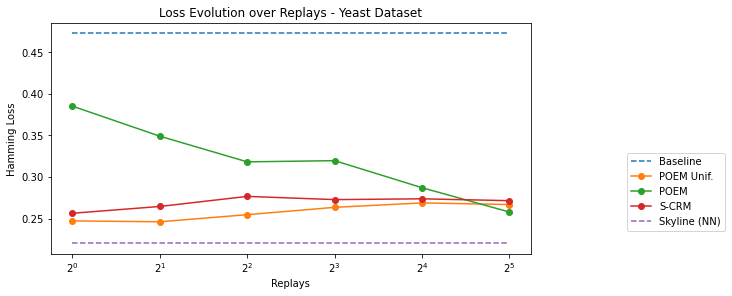

In [46]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
plt.title('Loss Evolution over Replays - Yeast Dataset')
ax.set_xlabel('Replays')
ax.set_xscale('log', base=2)
ax.plot(replay_targets, .473*np.ones_like(replay_targets), '--', label='Baseline')
ax.plot(replay_targets, ucrm_losses, 'o-', label='POEM Unif.')
ax.plot(replay_targets, crm_losses, 'o-', label='POEM')
ax.plot(replay_targets, scrm_losses, 'o-', label='S-CRM')
#ax.plot(replay_targets, .295*np.ones_like(replay_targets), '--', label='Skyline (LR)')
ax.plot(replay_targets, .220*np.ones_like(replay_targets), '--', label='Skyline (NN)')
ax.set_ylabel('Hamming Loss')
ax.legend(loc=(1.2, .1))

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier

In [48]:
mlp = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(500, 100, 40, 10,)), n_jobs=4).fit(X_train, y_train)

In [49]:
baseline_rewards = (1 - np.logical_xor(pi0.predict(X_test), y_test)).sum()*np.ones_like(crm_rewards)
skyline_rewards = (1 - np.logical_xor(mlp.predict(X_test), y_test)).sum()*np.ones_like(crm_rewards)

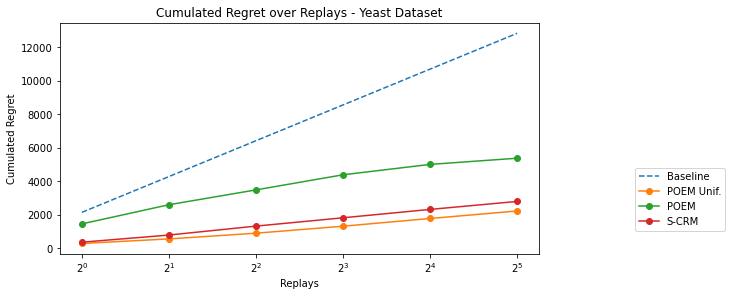

In [50]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
plt.title('Cumulated Regret over Replays - Yeast Dataset')
ax.set_xlabel('Replays')
ax.set_xscale('log', base=2)
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(baseline_rewards), '--', label='Baseline')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(ucrm_rewards), 'o-', label='POEM Unif.')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(crm_rewards), 'o-', label='POEM')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(scrm_rewards), 'o-', label='S-CRM')
# ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(skyline_rewards), '--', label='Skyline')
ax.set_ylabel('Cumulated Regret')
ax.legend(loc=(1.2, .1))